In [1]:
!pip install pyarrow
!pip install fastparquet

In [2]:
val_week = 104

In [3]:
import json
from tqdm import tqdm
import numpy as np, pandas as pd, datetime as dt
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
from collections import defaultdict

def iter_to_str(iterable):
    return " ".join(map(lambda x: str(0) + str(x), iterable))

In [15]:
df = pd.read_parquet('../input/hm-parquets-of-datasets/transactions_train.parquet')
sub = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv')
cid = pd.DataFrame(sub.customer_id.apply(lambda s: int(s[-16:], 16)))

In [5]:
from  gensim import models
# with open('../input/handmitem2vec/cust_buy104.json', "r") as f :
#     cust_buy = json.load(f)
#model = models.Word2Vec.load('../input/handmitem2vec/word2vec_v2_week104.model')

In [6]:
group = df.groupby('customer_id').sales_channel_id.mean().round().reset_index()\
    .merge(cid, on='customer_id', how='right').rename(columns={'sales_channel_id':'group'})
grouping = group.group.fillna(1.0)

# id of week to be used in a validation; set 105 if you would like to create a submission
val = df.loc[df.week == val_week].groupby('customer_id').article_id.apply(iter_to_str).reset_index()\
    .merge(cid, on='customer_id', how='right')
actual = val.article_id.apply(lambda s: [] if pd.isna(s) else s.split())
last_date = df.loc[df.week < val_week].t_dat.max()

## データ分析

In [8]:
# a = []
# buy = []
# actall = set()

# for i in tqdm(range(len(sub))) :
#     if len(actual[i]) == 0 :
#         a.append("")
#         buy.append("")
#     else :
#         actall = actall.union(actual[i])
#         a.append(" ".join(actual[i]))
#         cid = sub['customer_id'][i]
#         if cid not in cust_buy :
#             buy.append(" ")
#         else : buy.append(cust_buy[cid])


In [17]:
# s = pd.DataFrame({'customer_id': list(sub['customer_id']), 'buy' : buy, "actual" : a})
# s = s[s['actual'] != ""]

## 正解が購入品に含まれている確率

In [9]:
# cnt = 0
# tot = 0

# for i in range(len(s)) :
#     _, b, a = s.iloc[i]
#     a = a.split(" ")
#     b = b.split(" ")
#     for e in b :
#         tot += 1
#         if e in a :
#             cnt += 1

# cnt/tot, cnt, tot

In [10]:
# transactions = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv", dtype=str, encoding='utf8')
# articles = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv", dtype=str, encoding='utf8')
# customers = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/customers.csv", dtype=str, encoding='utf8')

In [11]:
# # 両方に共通して含まれないものはない
# x = set(transactions['article_id'])
# y = set(articles['article_id'])
# len(x - y) 

In [21]:
last_date

Timestamp('2020-09-15 00:00:00')

In [102]:
# 4日間の売れた商品リスト
init_date = last_date - dt.timedelta(days=11)
last_sell = df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)]
sell =  last_sell.groupby('customer_id')\
     .article_id.apply(iter_to_str).reset_index()\
     .merge(cid, on='customer_id', how='right').article_id.fillna('')

In [103]:
last_buy = defaultdict(list)
for i in tqdm(range(len(sub))) :
    x = set(sell[i].split(" ")) - set('')
    last_buy[sub['customer_id'][i]] = x

100%|██████████| 1371980/1371980 [00:17<00:00, 76471.83it/s]


In [104]:
last_buy['a3dbf5f0a5ec1df8da7f77855f118695ed6c7f5b6ea45dfe2c82a3f4f999542b']

{''}

In [20]:
# model = models.Word2Vec.load('../input/word2vec.model')

In [83]:
# cust_similar = dict()
# for i in tqdm(range(len(sub))): 
#     c = sub['customer_id'][i]
#     x = model.wv.most_similar(c, topn=10)
#     cust_similar[c] = x
# #     if i == 100 : break
# #     break

100%|██████████| 1371980/1371980 [7:09:16<00:00, 53.27it/s]  


In [84]:
# import pickle
# with open("cust_similar.pkl", "wb") as f :
#     pickle.dump(cust_similar, f)

1371980

In [95]:
with open("cust_similar.pkl", "rb") as f :
    cust_similar = pickle.load(f)
len(cust_similar)

In [105]:
l = []
tot = 0
hit = 0
hit2 = 0
for i in tqdm(range(len(sub))): 
    c = sub['customer_id'][i]
    x = cust_similar[c]
    t = []
    for e, _ in x :
#         print("--", last_buy[e], e)
        if last_buy[e] == {''}: continue
        t += last_buy[e]
    if len(actual[i]) != 0:
        cnt = 0
        tot += 1
        for v in t :
            if v in actual[i] :
                cnt+=1
        if cnt != 0 :
            hit += 1
            #print(i, cnt, hit, tot, set(t), actual[i])
        hit2 += cnt
    l.append(" ".join(set(t)))
#    if i == 10000: break
print(hit/tot, hit, tot, hit2)

100%|██████████| 1371980/1371980 [00:36<00:00, 38036.31it/s]

0.0625942247477676 4318 68984 6574


In [106]:
sub['cust_vec'] = l

In [107]:
#sub.to_csv('submission_cust104.csv', index=False)

In [108]:
sub

,customer_id,prediction,cust_vec
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...,
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...,
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...,
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...,
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...,
...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0706016001 0706016002 0372860001 0610776002 07...,0878510001 0880553002 0811397013 0881887001 08...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0706016001 0706016002 0372860001 0610776002 07...,0871710010 0859139003 0783346018 0751471037 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0706016001 0706016002 0372860001 0610776002 07...,
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0706016001 0706016002 0372860001 0610776002 07...,


In [109]:
import numpy as np, pandas as pd, datetime as dt
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
from collections import defaultdict

def iter_to_str(iterable):
    return " ".join(map(lambda x: str(0) + str(x), iterable))

def apk(actual, predicted, k=12):
    if len(predicted) > k:
        predicted = predicted[:k]
    score, nhits = 0.0, 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            nhits += 1.0
            score += nhits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=12, return_apks=False):
    assert len(actual) == len(predicted)
    apks = [apk(ac, pr, k) for ac, pr in zip(actual, predicted) if 0 < len(ac)]
    if return_apks:
        return apks
    return np.mean(apks)

def blend(dt, w=[], k=12):
    if len(w) == 0:
        w = [1] * (len(dt))
    preds = []
    for i in range(len(w)):
        preds.append(dt[i].split())
    res = {}
    for i in range(len(preds)):
        if w[i] < 0:
            continue
        for n, v in enumerate(preds[i]):
            if v in res:
                res[v] += (w[i] / (n + 1))
            else:
                res[v] = (w[i] / (n + 1))    
    res = list(dict(sorted(res.items(), key=lambda item: -item[1])).keys())
    return ' '.join(res[:k])

def prune(pred, ok_set, k=12):
    pred = pred.split()
    post = []
    for item in pred:
        if int(item) in ok_set and not item in post:
            post.append(item)
    return " ".join(post[:k])

def validation(actual, predicted, grouping, score=0, index=-1, ignore=False, figsize=(12, 6)):
    # actual, predicted : list of lists
    # group : pandas Series
    # score : pandas DataFrame
    
    vc = pd.Series(predicted).apply(len).value_counts()
    print("Fill Rate = ", round(1 - sum(vc[k] * (12 - k) / 12 for k in (set(range(12)) & set(vc.index))) / len(actual), 3) * 100)
    
    
    if ignore: return
    ap12 = mapk(actual, predicted, return_apks=True)
    map12 = round(np.mean(ap12), 6)
    if isinstance(score, int): score = pd.DataFrame({g:[] for g in sorted(grouping.unique().tolist())})
    if index == -1 : index = score.shape[0]
    score.loc[index, "All"] = map12
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1); sns.histplot(data=ap12, log_scale=(0, 10), bins=20); plt.title(f"MAP@12 : {map12}")
    for g in grouping.unique():
        map12 = round(mapk(actual[grouping == g], predicted[grouping == g]), 6)
        score.loc[index, g] = map12
    plt.subplot(1, 2, 2); score[[g for g in grouping.unique()[::-1]] + ['All']].loc[index].plot.barh(); plt.title(f"MAP@12 of Groups")
    vc = pd.Series(predicted).apply(len).value_counts()
    score.loc[index, "Fill"] = round(1 - sum(vc[k] * (12 - k) / 12 for k in (set(range(12)) & set(vc.index))) / len(actual), 3) * 100
    display(score)
    return score

Fill Rate =  16.1


,1.0,2.0,All,Fill
Simlar Customres,0.010723,0.012797,0.012111,16.1


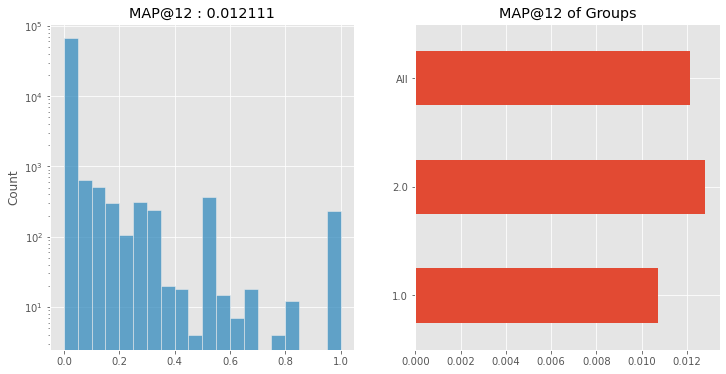

In [110]:
predicted = sub['cust_vec'].apply(lambda s: [] if pd.isna(s) else s.split())
#score = validation(actual, predicted, grouping, score, index='Similar Customers', ignore=(val_week == 105))
score = validation(actual, predicted, grouping, index='Simlar Customres', ignore=(val_week == 105))